In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import itertools
import time
from google.colab import output

In [ ]:
np.random.randn(1,4)*(20)

array([[ 17.32589792,  26.93115191,   3.3987162 , -21.52136177]])

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class GreenHouseEnv(object):
  def __init__(self,m,n,o):  #m, n and o is the dimension of the grid
    #self.grid = np.zeros((m,n))
    self.m = m
    self.n = n
    self.o = o
    self.occupied = []
    self.statePosDict ={}
    self.statePositionDict(m,n,o)
    #self.obsSpace = [[[k for k in range(self.o)] for j in range(self.n)] for i in range(self.m)]
    self.obsSpace = [i for i in range(self.m * self.n * self.o)]
    #print(self.obsSpace)
    self.actSpace = {'U': 0, 'D': 1, 'L': 2, 'R': 3, 'B': 4, 'F': 5}
    self.possibleAct = ['U','D','L','R', 'B', 'F']
    self.addComponents()
    self.rules_arr_rew = [9999,9999,0,0,9999,9999]
    self.objectives_comp_1 = {
        1: 'heater',
        2: 'water tank'
    }
    self.env_pos_log = []
    self.rew_vec = [99999,99999,0,0,99999,99999] #6 is number of objectives
    self.log_d = {0:[], 1: [], 2:[], 3:[], 4:[], 5:[], 6:[]}
    self.log_best_d =  {0:[], 1: [], 2:[], 3:[], 4:[], 5:[], 6:[]}
    self.rew_obtained =  {0:[], 1: [], 2:[], 3:[], 4:[], 5:[], 6:[]}
    self.best_pos = [999,999,999]
    self.best_pos_2 = [999,999]
    self.best_pos_3 = [0,0]
    self.best_pos_4 = [0,0]
    self.best_pos_5 = [999,999]
    self.best_pos_6 = [999,999]
    self.best_pos_log_2 =  []
    self.best_pos_log_3 =  []
    self.best_pos_log_4 =  []
    self.best_pos_log_5 =  []
    self.best_pos_log_6 =  []
    self.best_pos_log =  []
    self.prev_distance = [99999,99999,0,0,99999,99999] #to keep record of the prev distance
  
  def addComponents(self):
    self.components = [1,2,3,4,5,6,7,8] #[1,2,3,4,5,6,7,8,9,10]

    if len(self.components)> self.m*self.n*self.o:
      print('errorrrr')
      return 0

    
    self.comp_dictionary = {
        1: 'heater',
        2: 'water tank',
        3: 'pack soil',
        4: 'heat sensor',
        5: 'camera',
        6: 'fan',
        7: 'led',
        8: 'water pump',
        9: 'PCB',
        10: 'Pipes'
    }

    #self.grid = np.zeros((self.m,self.n,self.o))
    #print('grid: 111', self.grid)  
    
    len_com = len(self.components)
    i = 0
    while len_com != 0:
      #print('i',i)
      x = random.choice(range(0,self.m))
      y = random.choice(range(0,self.n))
      z = random.choice(range(0,self.o))
      if (x,y,z) not in self.occupied:
        #self.grid[x,y,z] = components[i]
        self.occupied.append((x,y,z))
        len_com -= 1
        i += 1
      

      #else:
      #  x = random.choice(range(0,self.m))
      #  y = random.choice(range(0,self.n))
      #  z = random.choice(range(0,self.o))
      #  self.grid[x,y,z] = components[i]
      #  self.occupied.append((x,y,z))
    #print('grid: ', np.shape(self.grid))   
    print('occupied:',self.occupied)

  def getComponentPosition(self, index):
    return self.occupied[index]

  def getComponentValue(self, pos):
    if pos in self.occupied:
      id = self.occupied.index(pos)
      val = self.components[id]
    else:
      val = -1
    return val

  def setState(self, state, comp_id):
    x,y,z = self.getComponentPosition(comp_id)
    #self.grid[x,y,z] = -1
    x,y,z = state
    #self.grid[x,y,z] = components[comp_id]
    self.occupied[comp_id] = state

  def totalDistance(self, components):
    total_dist = 0
    for i in range(len(components)):
      for j in range(len(components)):
        i_pos = self.getComponentPosition(i+1)
        j_pos = self.getComponentPosition(j+1)
        dist_temp = self.calcDistance(i_pos, j_pos)
        total_dist += dist_temp

    return total_dist


  def obj1(self):
    #print(self.rules_arr_rew)
    total = 0
    rew_comp = np.zeros(6) #6 here is number of objective
    temp_rew_vec = np.zeros(6)


    
    #rule 1 - minimize distance between pack soil, water tank and water pump
    #if component == 2 or component == 3 or component == 8:
    print('RULE 1')
    d1 = self.calcDistance(1,2)
    d2 = self.calcDistance(2,7)
    d3 = self.calcDistance(1,7)
    avg_d = (d1 + d2 + d3)/3
    #print('avg',avg_d)
      
    temp_rew_vec[0] = avg_d

    #find diff from last distance and new distance
    diff_1 = avg_d - self.rew_vec[0]
    diff_2 = self.prev_distance[0] - self.rew_vec[0]

    diff = diff_1 - diff_2

      
    #reward for moving closer or away from the best distance
    if avg_d>self.prev_distance[0]: # move away
      rew_comp[0] = -1
    elif avg_d<self.prev_distance[0]: # move closer
      #if it moves closer then check for the best score
      if avg_d<self.rew_vec[0]: #set a new best score
        rew_comp[0] = 10
        self.rew_vec[0] = avg_d
        pos1 = self.getComponentPosition(1)
        pos2 = self.getComponentPosition(2)
        pos3 = self.getComponentPosition(7)
        self.best_pos = [pos1, pos2, pos3]
        self.best_pos_log.append(self.best_pos)
      elif avg_d==self.rew_vec[0]: #find a similar best score
        rew_comp[0] = 5
        #add code here later to save the coordinates if it is different from the previous one
      else:
        rew_comp[0] = 2
    elif avg_d==self.prev_distance[0]: # stay in same place
      rew_comp[0] = 0.5

        

    #save the new distance as prev distance
    self.prev_distance[0] = avg_d
      
    '''
      if avg_d<self.rew_vec[0]:
        rew_comp[0] = 1
        self.rew_vec[0] = avg_d
        
      elif avg_d>self.rew_vec[0]:
        rew_comp[0] = -20
      else:
        rew_comp[0] = 0
      '''
    self.log_d[0].append(avg_d)
    self.log_best_d[0].append(self.rew_vec[0])
    self.rew_obtained[0].append(rew_comp[0])
    print('score obtained',rew_comp[0])
    print('avg_d', avg_d)
    print('slf.rew_vec', self.rew_vec[0])
    print('reward',rew_comp[0])
      
      #total += rew1
      #print('#MINIMIZE# old dist: ', self.rules_arr_rew[0], 'new dist:', avg_d ,'rew1:', rew1)
    '''
    #rule 2 - minimize distance between heater and the fan
    if component == 1 or component == 6:
      #print('RULE 2')
      #print(self.rules_arr_rew)
      hf = self.calcDistance(0,5)
      #print('dist',hf)
      
      temp_rew_vec[1] = hf
      if hf<self.rew_vec[1]:
        rew_comp[1] = 1
        
      elif hf > self.rew_vec[1]:
        rew_comp[1] = -1
      else:
        rew_comp[1] = 0
      #print('#MINIMIZE# old dist: ', self.rules_arr_rew[1],'new dist:', hf , 'rew2:', rew2)

    #rule 3 - maximize distance between LED and heat sensor
    if component == 4 or component == 7:
      #print('RULE 3')
      lhs = self.calcDistance(3,6)
      
      temp_rew_vec[2] = lhs
      if lhs>self.rew_vec[2]:
        rew_comp[2] = 1
        
      elif lhs < self.rew_vec[2]:
        rew_comp[2] = -1
      else:
        rew_comp[2] = 0
      
      #print('#MAXIMIZE# old dist: ', self.rules_arr_rew[2],'new dist:', lhs , 'rew3:', rew3)

    #rule 4 - maximize distance between heater and heat sensor
    
    if component == 1 or component == 4:
      #print('RULE 4')
      hhs = self.calcDistance(0,3)
      #print('hhs',hhs,'rules_arr',self.rules_arr_rew[3])
      
      temp_rew_vec[3] = hhs
      if hhs>self.rew_vec[3]:
        rew_comp[3] = 1
        
      elif hhs < self.rew_vec[3]:
        rew_comp[3] = -1
      else:
        rew_comp[3] = 0
      #print('#MAXIMIZE#  old dist: ', self.rules_arr_rew[3], 'new dist:', hhs ,'rew4:', rew4)
    
    #rule 5 - maximize lighting of pack soil by the LED
    if component == 7 or component == 3:
      #print('RULE 5')
      x_1, y_1, z_1 = self.getComponentPosition(3)
      z_1 = 0  #z moves to the top of the greenhouse
      x_2, y_2, z_2 = self.getComponentPosition(7)
      psl = math.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2 + (z_2 - z_1)**2)
      
      temp_rew_vec[4] = psl
      if psl>self.rew_vec[4]:
        rew_comp[4] = 1
        
      elif psl < self.rew_vec[4]:
        rew_comp[4] = -1
      else:
        rew_comp[4] = 0
      #print('#MAXIMIZE#  old dist: ', self.rules_arr_rew[4], 'new dist:', psl ,'rew5:', rew5)
    
    #rule 6 - maximize view of pack soil captured by the camera
    if component == 5 or component == 3:
      #print('RULE 6')
      x_1, y_1, z_1 = self.getComponentPosition(3)
      z_1 = 0  #z moves to the top of the greenhouse
      x_2, y_2, z_2 = self.getComponentPosition(5)
      psc = math.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2 + (z_2 - z_1)**2)
      
      temp_rew_vec[5] = psc
      if psc>self.rew_vec[5]:
        rew_comp[5] = 1
        
      elif psc < self.rew_vec[5]:
        rew_comp[5] = -1
      else:
        rew_comp[5] = 0
      #print('#MAXIMIZE#  old dist: ', self.rules_arr_rew[5], 'new dist:', psc , 'rew6:', rew6)
    '''
    return rew_comp,temp_rew_vec

  def obj2(self):
    #print(self.rules_arr_rew)
    total = 0
    rew_comp = np.zeros(6) #6 here is number of objective
    temp_rew_vec = np.zeros(6)
    
    #rule 2 - minimize distance between heater and the fan

    #if component == 1 or component == 6:
    #print('RULE 2')
    #print(self.rules_arr_rew)
    hf = self.calcDistance(0,5)
    #print('dist',hf)
    
    temp_rew_vec[0] = hf

    #find diff from last distance and new distance
    diff_1 = hf - self.rew_vec[1]
    diff_2 = self.prev_distance[1] - self.rew_vec[1]

    diff = diff_1 - diff_2

      
    #reward for moving closer or away from the best distance
    if hf>self.prev_distance[1]: # move away
      rew_comp[1] = -1
    elif hf<self.prev_distance[1]: # move closer
      #if it moves closer then check for the best score
      if hf<self.rew_vec[1]: #set a new best score
        rew_comp[1] = 10
        self.rew_vec[1] = hf
        pos1 = self.getComponentPosition(0)
        pos2 = self.getComponentPosition(5)
        self.best_pos_2 = [pos1, pos2]
        self.best_pos_log_2.append(self.best_pos_2)
      elif hf==self.rew_vec[1]: #find a similar best score
        rew_comp[1] = 5
        #add code here later to save the coordinates if it is different from the previous one
      else:
        rew_comp[1] = 2
    elif hf==self.prev_distance[1]: # stay in same place
      rew_comp[1] = 0.5

        

    #save the new distance as prev distance
    self.prev_distance[1] = hf
      
    '''
      if avg_d<self.rew_vec[0]:
        rew_comp[0] = 1
        self.rew_vec[0] = avg_d
        
      elif avg_d>self.rew_vec[0]:
        rew_comp[0] = -20
      else:
        rew_comp[0] = 0
      '''
    self.log_d[1].append(hf)
    self.log_best_d[1].append(self.rew_vec[1])
    self.rew_obtained[1].append(rew_comp[1])
    print('score obtained',rew_comp[1])
    print('avg_d', hf)
    print('slf.rew_vec', self.rew_vec[1])
    print('reward',rew_comp[1])
      
    return rew_comp,temp_rew_vec

  def obj3(self):

    #rule 3 - maximize distance between LED and heat sensor
    total = 0
    rew_comp = np.zeros(6) #6 here is number of objective
    temp_rew_vec = np.zeros(6)

    lhs = self.calcDistance(3,6)

    temp_rew_vec[0] = lhs
    
    #reward for moving closer or away from the best distance
    if lhs<self.prev_distance[2]: # move closer
      rew_comp[2] = -1
    elif lhs>self.prev_distance[2]: # move away
      #if it moves closer then check for the best score
      if lhs>self.rew_vec[2]: #set a new best score
        rew_comp[2] = 10
        self.rew_vec[2] = lhs
        pos1 = self.getComponentPosition(3)
        pos2 = self.getComponentPosition(6)
        self.best_pos_3 = [pos1, pos2]
        self.best_pos_log_3.append(self.best_pos_3)
      elif lhs==self.rew_vec[2]: #find a similar best score
        rew_comp[2] = 5
        #add code here later to save the coordinates if it is different from the previous one
      else:
        rew_comp[2] = 2
    elif lhs==self.prev_distance[2]: # stay in same place
      rew_comp[2] = 0.5
    
    self.prev_distance[2] = lhs
    
    self.log_d[2].append(lhs)
    self.log_best_d[2].append(self.rew_vec[2])
    self.rew_obtained[2].append(rew_comp[2])
    print('score obtained',rew_comp[2])
    print('avg_d', lhs)
    print('slf.rew_vec', self.rew_vec[2])
    print('reward',rew_comp[2])
      
    return rew_comp,temp_rew_vec

  def obj4(self):

    #rule 4 - maximize distance between heater and heat sensor
    total = 0
    rew_comp = np.zeros(6) #6 here is number of objective
    temp_rew_vec = np.zeros(6)

    hhs = self.calcDistance(0,3)

    temp_rew_vec[0] = hhs
    
    #reward for moving closer or away from the best distance
    if hhs<self.prev_distance[3]: # move closer
      rew_comp[3] = -1
    elif hhs>self.prev_distance[3]: # move away
      #if it moves closer then check for the best score
      if hhs>self.rew_vec[3]: #set a new best score
        rew_comp[3] = 10
        self.rew_vec[3] = hhs
        pos1 = self.getComponentPosition(0)
        pos2 = self.getComponentPosition(3)
        self.best_pos_4 = [pos1, pos2]
        self.best_pos_log_4.append(self.best_pos_4)
      elif hhs==self.rew_vec[3]: #find a similar best score
        rew_comp[3] = 5
        #add code here later to save the coordinates if it is different from the previous one
      else:
        rew_comp[3] = 2
    elif hhs==self.prev_distance[3]: # stay in same place
      rew_comp[3] = 0.5
    
    self.prev_distance[3] = hhs

    self.log_d[3].append(hhs)
    self.log_best_d[3].append(self.rew_vec[3])
    self.rew_obtained[3].append(rew_comp[3])
    print('score obtained',rew_comp[3])
    print('avg_d', hhs)
    print('slf.rew_vec', self.rew_vec[3])
    print('reward',rew_comp[3])
      
    return rew_comp,temp_rew_vec

  def obj5(self):

    #rule 5 - maximize lighting of pack soil by the LED
    total = 0
    rew_comp = np.zeros(6) #6 here is number of objective
    temp_rew_vec = np.zeros(6)

    x_1, y_1, z_1 = self.getComponentPosition(2)
    z_1 = 0  #z moves to the top of the greenhouse for ps(ideal led position)
    x_2, y_2, z_2 = self.getComponentPosition(6)
    psl = math.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2 + (z_2 - z_1)**2)
    

    temp_rew_vec[0] = psl
    
    #reward for moving closer or away from the best distance
    if psl>self.prev_distance[4]: # move away
      rew_comp[4] = -1
    elif psl<self.prev_distance[4]: # move closer
      #if it moves closer then check for the best score
      if psl<self.rew_vec[4]: #set a new best score
        rew_comp[4] = 10
        self.rew_vec[4] = psl
        pos1 = self.getComponentPosition(2)
        pos2 = self.getComponentPosition(6)
        self.best_pos_5 = [pos1, pos2]
        self.best_pos_log_5.append(self.best_pos_5)
      elif psl==self.rew_vec[4]: #find a similar best score
        rew_comp[4] = 5
        #add code here later to save the coordinates if it is different from the previous one
      else:
        rew_comp[4] = 2
    elif psl==self.prev_distance[4]: # stay in same place
      rew_comp[4] = 0.5
    
    self.prev_distance[4] = psl
    
    self.log_d[4].append(psl)
    self.log_best_d[4].append(self.rew_vec[4])
    self.rew_obtained[4].append(rew_comp[4])
    print('score obtained',rew_comp[4])
    print('avg_d', psl)
    print('slf.rew_vec', self.rew_vec[4])
    print('reward',rew_comp[4])
      
    return rew_comp,temp_rew_vec

  def obj6(self):

    #rule 6 - maximize view of pack soil captured by the camera
    total = 0
    rew_comp = np.zeros(6) #6 here is number of objective
    temp_rew_vec = np.zeros(6)

    x_1, y_1, z_1 = self.getComponentPosition(2)
    z_1 = 0  #z moves to the top of the greenhouse
    x_2, y_2, z_2 = self.getComponentPosition(4)
    psc = math.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2 + (z_2 - z_1)**2)

    temp_rew_vec[0] = psc
    
    #reward for moving closer or away from the best distance
    if psc>self.prev_distance[5]: # move away
      rew_comp[5] = -1
    elif psc<self.prev_distance[5]: # move closer
      #if it moves closer then check for the best score
      if psc<self.rew_vec[5]: #set a new best score
        rew_comp[5] = 10
        self.rew_vec[5] = psc
        pos1 = self.getComponentPosition(2)
        pos2 = self.getComponentPosition(4)
        self.best_pos_5 = [pos1, pos2]
        self.best_pos_log_5.append(self.best_pos_5)
      elif psc==self.rew_vec[5]: #find a similar best score
        rew_comp[5] = 5
        #add code here later to save the coordinates if it is different from the previous one
      else:
        rew_comp[5] = 2
    elif psc==self.prev_distance[5]: # stay in same place
      rew_comp[5] = 0.5
    
    self.prev_distance[5] = psc
    
    self.log_d[5].append(psc)
    self.log_best_d[5].append(self.rew_vec[5])
    self.rew_obtained[5].append(rew_comp[5])
    print('score obtained',rew_comp[5])
    print('avg_d', psc)
    print('slf.rew_vec', self.rew_vec[5])
    print('reward',rew_comp[5])
      
    return rew_comp,temp_rew_vec





  
  #handling in step func
  def avoidOffGrid(self, newState, oldState):
    if newState not in self.obsSpace:
      return True
    ##add code here

  def step(self, action, comp_id, obj): #,rule_val_arr
    
    obj_fun = {0:self.obj1 , 1:self.obj2, 2:self.obj3, 3:self.obj4, 4:self.obj5, 5:self.obj6}
    x,y,z = self.getComponentPosition(comp_id)
    if action == 0:
      #up
      if z == 0:  #checking end of grid
        new_z = z
        nextState = (x,y,new_z)
        
      elif self.getComponentValue((x,y,z-1)) > 0:
        new_z = z
        nextState = (x,y,new_z)
        
      else:
        new_z = z - 1
        nextState = (x,y,new_z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
      
    elif action == 1:
      #down
      if z == self.o-1:
        new_z = z
        nextState = (x,y,new_z)
      elif self.getComponentValue((x,y,z+1)) > 0:
        new_z = z
        nextState = (x,y,new_z)
      else:
        new_z = z + 1
        nextState = (x,y,new_z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
      
      
    elif action == 2:
      #left
      if x == 0:
        new_x = x
        nextState = (new_x,y,z)
      elif self.getComponentValue((x-1,y,z)) > 0:
        new_x = x
        nextState = (new_x,y,z)
      else:
        new_x = x - 1
        nextState = (new_x,y,z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
      

    elif action == 3:
      #right
      if x == self.m - 1:
        new_x = x
        nextState = (new_x,y,z)
      elif self.getComponentValue((x+1,y,z)) > 0:
        new_x = x
        nextState = (new_x,y,z)
      else:
        new_x = x + 1
        nextState = (new_x,y,z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
      

    elif action == 4:
      #front
      if y == 0:
        new_y = y
        nextState = (x,new_y,z)
      elif self.getComponentValue((x,y-1,z)) > 0:
        new_y = y
        nextState = (x,new_y,z)
      else:
        new_y = y - 1
        nextState = (x,new_y,z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
      

    elif action == 5:
      #back
      if y == self.n - 1:
        new_y = y
        nextState = (x,new_y,z)
      elif self.getComponentValue((x,y+1,z)) > 0:
        new_y = y
        nextState = (x,new_y,z)
      else:
        new_y = y + 1
        nextState = (x,new_y,z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
      

    elif action == 6:
      #don't move
      nextState = (x,y,z)
      self.setState(nextState,comp_id)
      st = self.posToState(tuple(nextState))
    temp1 = self.occupied
    self.env_pos_log.append(temp1) 
    t = comp_id + 1
    rew,trv = obj_fun[obj]()# self.rewardComponents(t)

    

    
    rew = list(rew)
    dom = rew.count(1)
    non_dom = rew.count(-1)
    #print('rew', rew)
    #print('dom', dom)
    #print('non dom', non_dom)
    '''
    if dom>non_dom:
      reward_ret = 1
      self.rew_vec = trv
      #print('mi aahe')
    elif dom<non_dom:
      reward_ret = -1
      #print('mi nai')
    else:
      reward_ret = 0.5
      if random.uniform(0,1) < 0.5:
        self.rew_vec = trv            
    '''

    

    '''
    dis = self.calcDistance(1,2)
    if dis <= self.dist_arr[0]:
      reward = 1
      self.dist_arr[0] = dis
    else:
      reward = -1
    '''
    #print('next state innn', st)
    return st, rew[obj], trv

  def tupleToState(self, tup):
    tem = ''
    for i in tup:
      s = str(i)
      tem = tem + s
    tem = int(tem)

    return tem

  

  def step_main(self,state, act,comp_id_1, comp_id_2):
    act_1 = int(act/7)
    act_2 = int(act%7)

    print('action 1: ', act_1)
    print('action 2: ', act_2)
    self.step(act_1,comp_id_1)
    self.step(act_2,comp_id_2)
    
    dis = self.calcDistance(comp_id_1,comp_id_2)
    if dis <= self.dist_arr[0]:
      reward = 1
    else:
      reward = -1
    
    idx1 = comp_id_1 - 1
    idx2 = comp_id_2 - 1

    pos1 = self.getComponentPosition(idx1)
    pos2 = self.getComponentPosition(idx2)
    print('Comp',comp_id_1,' pos is: ',pos1)
    print('Comp',comp_id_2,' pos is: ',pos2)

    next_state = pos1 + pos2
    next_state = self.tupleToState(next_state)

    if dis<= 3:
      done = True
    else:
      done = False

    return next_state, reward, done

  def statePositionDict(self,m,n,o):
    cnt = 0
    for i in range(m):
      for j in range(n):
        for k in range(o):
          self.statePosDict[cnt] = (i,j,k)
          cnt += 1
    
  def posToState(self,tup):
    #print(self.statePosDict)
    for k,v in self.statePosDict.items():
      if v == tup:
        ptos = k
    return ptos

  def stateToPos(self,s):
    ret = self.statePosDict[s]

    return ret


  def calcDistance(self, comp_id_1, comp_id_2):
    x_1, y_1, z_1 = self.getComponentPosition(comp_id_1)
    x_2, y_2, z_2 = self.getComponentPosition(comp_id_2)
    dist = math.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2 + (z_2 - z_1)**2)
    return dist

  
  def reset(self):
    #self.grid = np.zeros((self.m, self.n,self.o))
    self.__init__(self.m, self.n,self.o)

  def render(self):
    #print(self.occupied)
    print('components',self.components)
    #print(
    #    '#####################################################################'+
    #    '#####################################################################'
    #    +'########################')
    x = []
    y = []
    z = []
    for tup in self.occupied:
      x.append(tup[0])
      y.append(tup[1])
      z.append(tup[2])
    
    print('*****FRONT VIEW*****')
    print('Z_AXIS \u2193')
    
    i=1
    for y_id in range(self.n):
      print('LAYER_',y_id)
      for i in range(self.m):
        print('################',end='')
      print()
      for z_id in range((self.o)):
        for x_id in range((self.m)):
          print('|',end='\t')
          temp = self.getComponentValue((x_id,y_id,z_id))
          if temp>0:
            print(temp,end='\t')
            #i+=1
          else:
            print(-1, end='\t')
        print('|',end='\t')
        print()
        for i in range(self.m):
          print('################',end='')
        print()
    print('X_AXIS \u2192')
    print('\n\n')
    print('*****TOP VIEW*****')
    print('Y_AXIS \u2193')
    
    i=1
    for z_id in range(self.o):
      print('LAYER_',z_id)
      for i in range(self.m):
        print('################',end='')
      print()
      for y_id in range((self.n)):
        for x_id in range((self.m)):
          print('|',end='\t')
          temp = self.getComponentValue((x_id,y_id,z_id))
          if temp>0:
            print(temp,end='\t')
          #  i+=1
          else:
            print(-1, end='\t')
        print('|',end='\t')
        print()
        for i in range(self.m):
          print('################',end='')
        print()
      print('X_AXIS \u2192')
        



In [ ]:
from collections import defaultdict
class Agent:
  def __init__(self, eps_prob):
    self.time_step = 0
    self.eps_prob = eps_prob
    self.total_rew = 0
    self.prev_action = None
    self.action_cnt = 0
    self.action_log = []
    self.env_pos_log = []
    self.obj_pos = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}
    

  def greedy_eps(self, Q, eps, num_act):
    #https://www.geeksforgeeks.org/q-learning-in-python/
    #https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

    def policyFunc(state):
      act_prob = np.ones(num_act, dtype = float) * eps / num_act

      best_act = np.argmax(Q[state])
      act_prob[best_act] += (1 - eps)
      
      return act_prob

    return policyFunc

  def qLearning(self, env, nS, nA, num_episodes, disc_fac = 1.0, alpha = 0.5, epsilon = 0.1):
    
    '''
    Q_1 = np.zeros((nS,nA)) #num of action hardcoded
    Q_2 = np.zeros((nS,nA))
    Q_3 = np.zeros((nS,nA))
    Q_4 = np.zeros((nS,nA))
    Q_5 = np.zeros((nS,nA))
    Q_6 = np.zeros((nS,nA))
    '''

    Q_1 = np.zeros((nS,nA))
    Q_2 = np.zeros((nS,nA))
    Q_3 = np.zeros((nS,nA))
    Q_4 = np.zeros((nS,nA))
    Q_5 = np.zeros((nS,nA))
    Q_6 = np.zeros((nS,nA))
    Q = np.zeros((nS,nA))

    #num_obj = 2

    obj_dict = {0:[1,2,7], 1:[0,5], 2:[3,6], 3:[0,3], 4:[2,6], 5:[2,4]} #0:[1,2,7], 1:[0,5], 2:[3,6], 3:[0,3], 4:[2,6], 5:[2,4]
    
    env.reset()

    step_cnt = 0

    reward_total = 0

    lr = 0.9

    y = 0.95

    paretoList = []


    check_arr = []
    while reward_total<50000:

    #for x in range(num_episodes):
      check_arr.append(step_cnt)
      step_cnt += 1

      for obj in obj_dict:
        
        for i in obj_dict[obj]:
          
          
          state = env.getComponentPosition(i)
          state = env.posToState(state)
          done = False
          
          start = time.time()

          reward_log = [] #np.array(3000)

          
          
          reward_total_log = [] #np.array(7)

          while not done:
            #if step_cnt % 200 == 0:
            

            print('env occ', env.occupied)
            print('log', env.env_pos_log)

            step_cnt += 1

            '''
            if random.uniform(0,1) < epsilon:
              action = np.random.choice(7)
              self.action_log.append(0) # 0 for random action
            else:
              if obj == 0:
                action = np.argmax(Q_1[state])
              elif obj == 1:
                action = np.argmax(Q_2[state])
              elif obj == 2:
                action = np.argmax(Q_3[state])
              elif obj == 3:
                action = np.argmax(Q_4[state])
              elif obj == 4:
                action = np.argmax(Q_5[state])
              elif obj == 5:
                action = np.argmax(Q_6[state])
              self.action_log.append(1) # 1 for best action
            #print('action',action)
            '''

            action = np.argmax(Q[state, :] + np.random.randn(1,7)*20)



            next_state, reward, dist = env.step(action, i, obj)

            reward_total += reward

            print('reward total', reward_total)
            reward_log.append(reward)

            obj1_w = 0.1666
            obj2_w = 0.1666
            obj3_w = 0.1666
            obj4_w = 0.1666
            obj5_w = 0.1666
            obj6_w = 0.1666



            if obj == 0:
              old_val = Q_1[state, action]
              next_max = np.max(Q_1[next_state])

              #new_value = (1 - alpha) * old_val + alpha * (reward + disc_fac * next_max)

              Q_1[state,action] = Q_1[state,action] + lr*((obj1_w) * y*np.max(Q_1[state,:]) - Q_1[state,action])

              Q[state,action] = obj1_w*Q_1[state,action] + obj2_w*Q_2[state,action] + obj3_w*Q_3[state,action] + obj4_w*Q_4[state,action] + obj5_w*Q_5[state,action] + obj6_w*Q_6[state,action]

              state = next_state

              avg_d_glog = np.array(env.log_d[0])

              best_d_glog = np.array(env.log_best_d[0])

              rew_obt_glog = np.array(env.rew_obtained[0])

              reward_avg_d_file_name = 'avg_d_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy', avg_d_glog)
              
              reward_best_d_file_name = 'best_d_glog'+str(obj)+'_'+str(i)
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy', best_d_glog)

              reward_rew_obt_file_name = 'rew_obt_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy', rew_obt_glog)

              reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy', env.best_pos_log)

              
            
            elif obj == 1:
              old_val = Q_2[state, action]
              next_max = np.max(Q_2[next_state])

              #new_value = (1 - alpha) * old_val + alpha * (reward + disc_fac * next_max)

              #Q_2[state,action] = new_value

              Q_2[state,action] = Q_2[state,action] + lr*((obj2_w) * y*np.max(Q_2[state,:]) - Q_2[state,action])

              Q[state,action] = obj1_w*Q_1[state,action] + obj2_w*Q_2[state,action] + obj3_w*Q_3[state,action] + obj4_w*Q_4[state,action] + obj5_w*Q_5[state,action] + obj6_w*Q_6[state,action]

              state = next_state

              avg_d_glog = np.array(env.log_d[1])

              best_d_glog = np.array(env.log_best_d[1])

              rew_obt_glog = np.array(env.rew_obtained[1])

              reward_avg_d_file_name = 'avg_d_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy', avg_d_glog)
              reward_best_d_file_name = 'best_d_glog'+str(obj)+'_'+str(i)
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy', best_d_glog)

              reward_rew_obt_file_name = 'rew_obt_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy', rew_obt_glog)

              reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy', env.best_pos_log_2)

            
            elif obj == 2:
              old_val = Q_3[state, action]
              next_max = np.max(Q_3[next_state])

              Q_3[state,action] = Q_3[state,action] + lr*((obj3_w) * y*np.max(Q_3[state,:]) - Q_3[state,action])

              Q[state,action] = obj1_w*Q_1[state,action] + obj2_w*Q_2[state,action] + obj3_w*Q_3[state,action] + obj4_w*Q_4[state,action] + obj5_w*Q_5[state,action] + obj6_w*Q_6[state,action]

              state = next_state

              avg_d_glog = np.array(env.log_d[2])

              best_d_glog = np.array(env.log_best_d[2])

              rew_obt_glog = np.array(env.rew_obtained[2])

              reward_avg_d_file_name = 'avg_d_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy', avg_d_glog)
              reward_best_d_file_name = 'best_d_glog'+str(obj)+'_'+str(i)
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy', best_d_glog)

              reward_rew_obt_file_name = 'rew_obt_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy', rew_obt_glog)

              reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy', env.best_pos_log_3)
            
            elif obj == 3:
              old_val = Q_4[state, action]
              next_max = np.max(Q_4[next_state])

              Q_4[state,action] = Q_4[state,action] + lr*((obj4_w) * y*np.max(Q_4[state,:]) - Q_4[state,action])

              Q[state,action] = obj1_w*Q_1[state,action] + obj2_w*Q_2[state,action] + obj3_w*Q_3[state,action] + obj4_w*Q_4[state,action] + obj5_w*Q_5[state,action] + obj6_w*Q_6[state,action]

              state = next_state

              avg_d_glog = np.array(env.log_d[3])

              best_d_glog = np.array(env.log_best_d[3])

              rew_obt_glog = np.array(env.rew_obtained[3])

              reward_avg_d_file_name = 'avg_d_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy', avg_d_glog)
              reward_best_d_file_name = 'best_d_glog'+str(obj)+'_'+str(i)
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy', best_d_glog)

              reward_rew_obt_file_name = 'rew_obt_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy', rew_obt_glog)

              reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy', env.best_pos_log_4)

            elif obj == 4:
              old_val = Q_5[state, action]
              next_max = np.max(Q_5[next_state])

              Q_5[state,action] = Q_5[state,action] + lr*((obj5_w) * y*np.max(Q_5[state,:]) - Q_5[state,action])

              Q[state,action] = obj1_w*Q_1[state,action] + obj2_w*Q_2[state,action] + obj3_w*Q_3[state,action] + obj4_w*Q_4[state,action] + obj5_w*Q_5[state,action] + obj6_w*Q_6[state,action]

              state = next_state

              avg_d_glog = np.array(env.log_d[4])

              best_d_glog = np.array(env.log_best_d[4])

              rew_obt_glog = np.array(env.rew_obtained[4])

              reward_avg_d_file_name = 'avg_d_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy', avg_d_glog)
              reward_best_d_file_name = 'best_d_glog'+str(obj)+'_'+str(i)
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy', best_d_glog)

              reward_rew_obt_file_name = 'rew_obt_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy', rew_obt_glog)

              reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy', env.best_pos_log_4)

            elif obj == 5:
              old_val = Q_6[state, action]
              next_max = np.max(Q_6[next_state])

              Q_6[state,action] = Q_6[state,action] + lr*((obj6_w) * y*np.max(Q_6[state,:]) - Q_6[state,action])

              Q[state,action] = obj1_w*Q_1[state,action] + obj2_w*Q_2[state,action] + obj3_w*Q_3[state,action] + obj4_w*Q_4[state,action] + obj5_w*Q_5[state,action] + obj6_w*Q_6[state,action]

              state = next_state

              avg_d_glog = np.array(env.log_d[5])

              best_d_glog = np.array(env.log_best_d[5])

              rew_obt_glog = np.array(env.rew_obtained[5])

              reward_avg_d_file_name = 'avg_d_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy', avg_d_glog)
              reward_best_d_file_name = 'best_d_glog'+str(obj)+'_'+str(i)
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy', best_d_glog)

              reward_rew_obt_file_name = 'rew_obt_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy', rew_obt_glog)

              reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(obj)+'_'+str(i)        
              np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy', env.best_pos_log_4)
            
            for ind in range(8):
              self.obj_pos[ind].append(env.getComponentPosition(ind))
              


            end = time.time()

            diff = end - start

          
            
            val = 0
            if val==0:# or diff>90: #actual code was reward>=0 then done
              done = True
              #print('ep:',x)
              #print('rew_tot', reward_total)
              #print('diff', diff)

          #log reward total outside the if loop
          #log distance for each inside the if condition
          #log individual reward inside the if condition
          #log best distance inside the if condition
          
          #reward_total_log.append(reward_total)

          #reward_log = np.array(reward_log)
          #reward_total_log = np.array(reward_total_log)

          #reward_file_name = 'reward_random_'+str(x)+'_'+str(i)

                  
          
          
          reward_act_log_obt_file_name = 'rew_act_glog'+str(obj)+'_'+str(i)        
          np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_act_log_obt_file_name+'.npy', self.action_log)

        output.clear()
        #np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_file_name+'.npy', reward_log)
      
        #reward_total_file_name = 'reward_total_random_'+str(num_episodes)
        #np.save('/content/drive/MyDrive/DesignBot_Numpy/'+reward_total_file_name+'.npy', reward_total_log)

      paretoList.append([env.log_d[0][-1],env.log_d[1][-1],env.log_d[2][-1],env.log_d[3][-1],env.log_d[4][-1],env.log_d[5][-1]])
      



      #comment 1 starts here
      '''
      paretoFront = []

      paretoFront1 = []

      for each in paretoList:
        paretoFront.append(each)
        for e in paretoList:
           if((e[1]<each[1] and e[2]>=each[2] and e[3]>=each[3] and e[4]<=each[4] and e[5]<=each[5] and e[0]<=each[0])
          or (e[1]<=each[1] and e[2]>each[2] and e[3]>=each[3] and e[4]<=each[4] and e[5]<=each[5] and e[0]<=each[0])
          or (e[1]<=each[1] and e[2]>=each[2] and e[3]>each[3] and e[4]<=each[4] and e[5]<=each[5] and e[0]<=each[0])
          or (e[1]<=each[1] and e[2]>=each[2] and e[3]>=each[3] and e[4]<each[4] and e[5]<=each[5] and e[0]<=each[0])
          or (e[1]<=each[1] and e[2]>=each[2] and e[3]>=each[3] and e[4]<=each[4] and e[5]<each[5] and e[0]<=each[0])
          or (e[1]<=each[1] and e[2]>=each[2] and e[3]>=each[3] and e[4]<=each[4] and e[5]<=each[5] and e[0]<each[0])):
            paretoFront.remove(each) #each gets removed as e is dominating
            paretoList.remove(each)
            break

      

      for each in paretoFront:
        if each not in paretoFront1:
          paretoFront1.append(each)
      #print('log d len',len(env.log_d[0][-1]))
    '''
    #comment 2 ends here

    S=[[] for i in range(0,len(paretoList))]
    front = [[]]
    front_val = [[]]
    n=[0 for i in range(0,len(paretoList))]
    rank = [0 for i in range(0, len(paretoList))]
    

    for p in range(0, len(paretoList)):
      n[p] = 0
      S[p] = []
      
      for q in range(0, len(paretoList)):
        if (p!=q):
          if ((paretoList[p][0]<paretoList[q][0] and paretoList[p][1]<=paretoList[q][1] and paretoList[p][2]>=paretoList[q][2] and paretoList[p][3]>=paretoList[q][3] and paretoList[p][4]<=paretoList[q][4] and paretoList[p][5]<=paretoList[q][5])
          or (paretoList[p][0]<=paretoList[q][0] and paretoList[p][1]<paretoList[q][1] and paretoList[p][2]>=paretoList[q][2] and paretoList[p][3]>=paretoList[q][3] and paretoList[p][4]<=paretoList[q][4] and paretoList[p][5]<=paretoList[q][5])
          or (paretoList[p][0]<=paretoList[q][0] and paretoList[p][1]<=paretoList[q][1] and paretoList[p][2]>paretoList[q][2]) and paretoList[p][3]>=paretoList[q][3] and paretoList[p][4]<=paretoList[q][4] and paretoList[p][5]<=paretoList[q][5]
          or (paretoList[p][0]<=paretoList[q][0] and paretoList[p][1]<=paretoList[q][1] and paretoList[p][2]>=paretoList[q][2]) and paretoList[p][3]>paretoList[q][3] and paretoList[p][4]<=paretoList[q][4] and paretoList[p][5]<=paretoList[q][5]
          or (paretoList[p][0]<=paretoList[q][0] and paretoList[p][1]<=paretoList[q][1] and paretoList[p][2]>=paretoList[q][2]) and paretoList[p][3]>=paretoList[q][3] and paretoList[p][4]<paretoList[q][4] and paretoList[p][5]<=paretoList[q][5]
          or (paretoList[p][0]<=paretoList[q][0] and paretoList[p][1]<=paretoList[q][1] and paretoList[p][2]>=paretoList[q][2]) and paretoList[p][3]>=paretoList[q][3] and paretoList[p][4]<=paretoList[q][4] and paretoList[p][5]<paretoList[q][5]): #p dominates q
            S[p].append(q)
            
          if ((paretoList[p][0]>paretoList[q][0] and paretoList[p][1]>=paretoList[q][1] and paretoList[p][2]<=paretoList[q][2] and paretoList[p][3]<=paretoList[q][3] and paretoList[p][4]>=paretoList[q][4] and paretoList[p][5]>=paretoList[q][5])
          or (paretoList[p][0]>=paretoList[q][0] and paretoList[p][1]>paretoList[q][1] and paretoList[p][2]<=paretoList[q][2] and paretoList[p][3]<=paretoList[q][3] and paretoList[p][4]>=paretoList[q][4] and paretoList[p][5]>=paretoList[q][5])
          or (paretoList[p][0]>=paretoList[q][0] and paretoList[p][1]>=paretoList[q][1] and paretoList[p][2]<paretoList[q][2]) and paretoList[p][3]<=paretoList[q][3] and paretoList[p][4]>=paretoList[q][4] and paretoList[p][5]>=paretoList[q][5]
          or (paretoList[p][0]>=paretoList[q][0] and paretoList[p][1]>=paretoList[q][1] and paretoList[p][2]<=paretoList[q][2]) and paretoList[p][3]<paretoList[q][3] and paretoList[p][4]>=paretoList[q][4] and paretoList[p][5]>=paretoList[q][5]
          or (paretoList[p][0]>=paretoList[q][0] and paretoList[p][1]>=paretoList[q][1] and paretoList[p][2]<=paretoList[q][2]) and paretoList[p][3]<=paretoList[q][3] and paretoList[p][4]>paretoList[q][4] and paretoList[p][5]>=paretoList[q][5]
          or (paretoList[p][0]>=paretoList[q][0] and paretoList[p][1]>=paretoList[q][1] and paretoList[p][2]<=paretoList[q][2]) and paretoList[p][3]<=paretoList[q][3] and paretoList[p][4]>=paretoList[q][4] and paretoList[p][5]>paretoList[q][5]): #q dominates p
            n[p] = n[p] + 1
        
      if n[p] == 0:
        rank[p] = 0
        if p not in front[0]:  #adding distinct solutions to first front
          front[0].append(p)
          front_val[0].append(paretoList[p])
          

      
    i = 0
    while (front[i] != []): #empty
      Q_P = []
      Q_Pval = []
      for p in front[i]:
        for q in S[p]:
          n[q] = n[q] - 1
          if (n[q] == 0):
            rank[q] = i+1
            if q not in Q_P:
              Q_P.append(q)
              Q_Pval.append(paretoList[q])
              
        
      i = i+1
      front.append(Q_P)
      front_val.append(Q_Pval)
      
        
              
    del front[len(front)-1]
    del front_val[len(front_val)-1]

    paretoFront = np.array(front)
    np.save('/content/drive/MyDrive/DesignBot_Numpy/pareto_front.npy', paretoFront)
    paretoFrontVal = np.array(front_val)
    np.save('/content/drive/MyDrive/DesignBot_Numpy/pareto_front_val.npy', paretoFrontVal)

    '''
    print('Pareto Front')
    paretoFront = []
    paretoRem = []
    for each in paretoList:
      paretoFront.append(each)
      for e in paretoList:
        if((e[1]<each[1] and e[2]>each[2] and e[3]>each[3] and e[4]<each[4] and e[5]<each[5] and e[0]<=each[0])
        or (e[1]<=each[1] and e[2]>each[2] and e[3]>each[3] and e[4]<each[4] and e[5]<each[5] and e[0]<each[0])
        or (e[1]<each[1] and e[2]>=each[2] and e[3]>each[3] and e[4]<each[4] and e[5]<each[5] and e[0]<each[0])
        or (e[1]<=each[1] and e[2]>each[2] and e[3]>=each[3] and e[4]<each[4] and e[5]<each[5] and e[0]<each[0])
        or (e[1]<=each[1] and e[2]>each[2] and e[3]>each[3] and e[4]<=each[4] and e[5]<each[5] and e[0]<each[0])
        or (e[1]<=each[1] and e[2]>each[2] and e[3]>each[3] and e[4]<each[4] and e[5]<=each[5] and e[0]<each[0])):
          paretoFront.remove(each) #each gets removed as e is dominating
          paretoList.remove(each)
          paretoRem.append([e[1],each[1]])
          break
    
    paretoFront1 = []    #remove duplicate solutions
    
    for each in paretoFront:
      if each not in paretoFront1:
        paretoFront1.append(each)

    print('The solution in pareto front have distance of obj 1 and obj 2 resp')
    print(paretoFront1)
    print('The solution removed')
    print(paretoRem)
    paretoFront1 = np.array(paretoFront1)
   

    print('PARETO', paretoFront1)
    np.save('/content/drive/MyDrive/DesignBot_Numpy/pareto_front.npy', paretoFront1)
     '''

    env_occ_file_name = 'env_occ_glog'        
    np.save('/content/drive/MyDrive/DesignBot_Numpy/'+env_occ_file_name+'.npy', self.env_pos_log)

    print('CHECK', check_arr)
    #print('OBJ POS', obj_pos[0])

In [ ]:
obj_dict = {6: [1,2], 7: [3,4]}
for obj in obj_dict:
  for i in obj_dict[obj]:
    print(obj)
obj_dict[6].append(5)

6
6
7
7


In [ ]:
try_dict = {1: []}
try_dict[1].append(0)
try_dict[1]

[0]

In [ ]:
obj_dict[6]

[1, 2, 5]

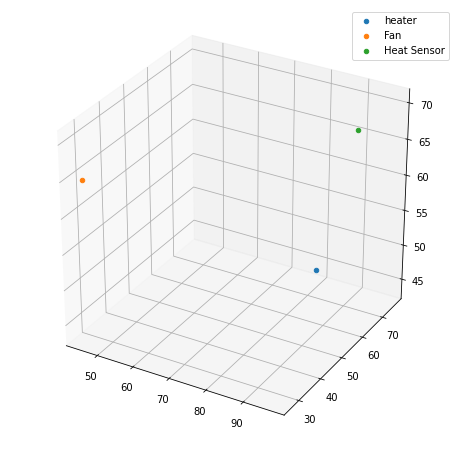

In [ ]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(79, 76, 44, label='heater')
ax.scatter(45, 27, 65, label='Fan')
ax.scatter(97, 62, 70, label='Heat Sensor')
plt.legend()
plt.show()

In [ ]:
env = GreenHouseEnv(100 ,100, 100)

occupied: [(79, 99, 87), (42, 57, 62), (26, 26, 85), (47, 49, 58), (21, 72, 81), (1, 22, 61), (47, 4, 21), (75, 0, 0)]


In [ ]:
agent = Agent(0.1)

In [ ]:
agent.qLearning(env=env,nS=100*100*100,nA=7,num_episodes=10000)

env occ [(97, 55, 26), (58, 32, 1), (47, 12, 32), (38, 93, 67), (59, 93, 81), (87, 43, 66), (73, 60, 86), (88, 61, 70)]
log 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



score obtained 2.0
avg_d 101.61200716450787
slf.rew_vec 80.4114419718985
reward 2.0
reward total 21471.5


In [ ]:
pip install celluloid

In [ ]:
from copy import deepcopy
temp_list = deepcopy(agent.obj_pos)

In [ ]:
len(agent.obj_pos[0])

1791

In [ ]:
len(temp_list[0])

1791

In [ ]:
temp_list[0].pop(0)

(1, 2, 0)

0
1791
50
1790
100
1789
150
1788
200
1787
250
1786
300
1785
350
1784
400
1783
450
1782
500
1781
550
1780
600
1779
650
1778
700
1777
750
1776
800
1775
850
1774
900
1773
950
1772
1000
1771
1050
1770
1100
1769
1150
1768
1200
1767
1250
1766
1300
1765
1350
1764
1400
1763
1450
1762
1500
1761
1550
1760
1600
1759
1650
1758
1700
1757
1750
1756
0
1791
50
1790
100
1789
150
1788
200
1787
250
1786
300
1785
350
1784
400
1783
450
1782
500
1781
550
1780
600
1779
650
1778
700
1777
750
1776
800
1775
850
1774
900
1773
950
1772
1000
1771
1050
1770
1100
1769
1150
1768
1200
1767
1250
1766
1300
1765
1350
1764
1400
1763
1450
1762
1500
1761
1550
1760
1600
1759
1650
1758
1700
1757
1750
1756
0
1791
50
1790
100
1789
150
1788
200
1787
250
1786
300
1785
350
1784
400
1783
450
1782
500
1781
550
1780
600
1779
650
1778
700
1777
750
1776
800
1775
850
1774
900
1773
950
1772
1000
1771
1050
1770
1100
1769
1150
1768
1200
1767
1250
1766
1300
1765
1350
1764
1400
1763
1450
1762
1500
1761
1550
1760
1600
1759
1650
1758
1700
1757

No handles with labels found to put in legend.


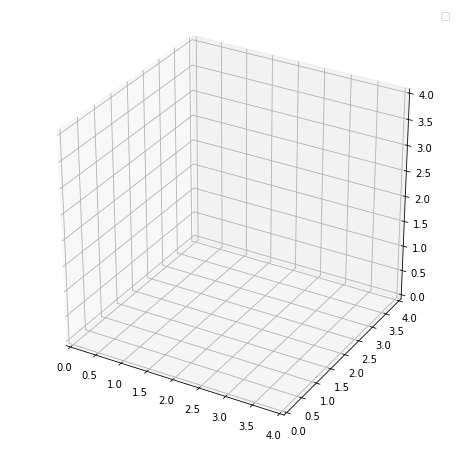

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from celluloid import Camera
from copy import deepcopy

obj_dict = {0:[1,2,7], 1:[0,5], 2:[3,6], 3:[0,3], 4:[2,6], 5:[2,4]}
fig = plt.figure(figsize=(8,8))
camera = Camera(fig) #plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0, 4)
ax.set_ylim3d(0, 4)
ax.set_zlim3d(0, 4)

temp_list = deepcopy(agent.obj_pos)

for obj in obj_dict:
  for i in obj_dict[obj]:
    #print(i)
    step1 = 0
    for j in range(len(temp_list[i])-1):
      #print(len(temp_list))
      if step1 % 50 == 0:
        print(step1)
        
        print(len(temp_list[i]))
        
        #ax.scatter(temp_list[0][0][0],temp_list[0][0][1],temp_list[0][0][2], c = '000000')
        ax.scatter(temp_list[1][0][0],temp_list[1][0][1],temp_list[1][0][2], c = '#FF0000')
        ax.scatter(temp_list[2][0][0],temp_list[2][0][1],temp_list[2][0][2], c = '#00FF00')
        #ax.scatter(temp_list[3][0][0],temp_list[3][0][1],temp_list[3][0][2], c = '#0000FF')
        #ax.scatter(temp_list[4][0][0],temp_list[4][0][1],temp_list[4][0][2], c = '#FFFF00')
        #ax.scatter(temp_list[5][0][0],temp_list[5][0][1],temp_list[5][0][2], c = '#00FFFF')
        #ax.scatter(temp_list[6][0][0],temp_list[6][0][1],temp_list[6][0][2], c = '#FF00FF')
        ax.scatter(temp_list[7][0][0],temp_list[7][0][1],temp_list[7][0][2], c = '#C0C0C0')
        temp_list[i].pop(0)
        #print(temp_list[0])
        #ax.scatter(lss[i,0],lss[i,1],lss[i,2], color = '#FF0000')
        #ax.scatter(i, 62, 70)
        camera.snap()
      step1 += 1
anim = camera.animate(blit=True)
plt.legend()
plt.show()
anim.save('scatter.mp4') #,fps=40, dpi=80


In [ ]:
len(temp_list[0])

530

In [ ]:
env.getComponentPosition(0)

(10, 72, 61)

In [ ]:
agent.env_pos_log

[[(40, 64, 72),
  (13, 93, 88),
  (32, 56, 25),
  (48, 72, 18),
  (46, 47, 97),
  (24, 55, 79),
  (46, 2, 84),
  (24, 32, 0)],
 [(40, 64, 72),
  (13, 93, 88),
  (32, 56, 25),
  (48, 72, 18),
  (46, 47, 97),
  (24, 55, 79),
  (46, 2, 84),
  (24, 32, 0)],
 [(40, 64, 72),
  (13, 93, 88),
  (32, 56, 25),
  (48, 72, 18),
  (46, 47, 97),
  (24, 55, 79),
  (46, 2, 84),
  (24, 32, 0)],
 [(40, 64, 72),
  (13, 93, 88),
  (32, 56, 25),
  (48, 72, 18),
  (46, 47, 97),
  (24, 55, 79),
  (46, 2, 84),
  (24, 32, 0)],
 [(40, 64, 72),
  (13, 93, 88),
  (32, 56, 25),
  (48, 72, 18),
  (46, 47, 97),
  (24, 55, 79),
  (46, 2, 84),
  (24, 32, 0)],
 [(40, 64, 72),
  (13, 93, 88),
  (32, 56, 25),
  (48, 72, 18),
  (46, 47, 97),
  (24, 55, 79),
  (46, 2, 84),
  (24, 32, 0)],
 [(40, 64, 72),
  (13, 93, 88),
  (32, 56, 25),
  (48, 72, 18),
  (46, 47, 97),
  (24, 55, 79),
  (46, 2, 84),
  (24, 32, 0)],
 [(40, 64, 72),
  (13, 93, 88),
  (32, 56, 25),
  (48, 72, 18),
  (46, 47, 97),
  (24, 55, 79),
  (46, 2, 84),


In [ ]:
agent.env_pos_log

[[(18, 38, 40),
  (72, 94, 75),
  (43, 15, 93),
  (41, 4, 82),
  (52, 31, 74),
  (15, 34, 13),
  (91, 6, 86),
  (57, 53, 48)],
 [(18, 38, 40),
  (72, 94, 75),
  (43, 15, 93),
  (41, 4, 82),
  (52, 31, 74),
  (15, 34, 13),
  (91, 6, 86),
  (57, 53, 48)],
 [(18, 38, 40),
  (72, 94, 75),
  (43, 15, 93),
  (41, 4, 82),
  (52, 31, 74),
  (15, 34, 13),
  (91, 6, 86),
  (57, 53, 48)],
 [(18, 38, 40),
  (72, 94, 75),
  (43, 15, 93),
  (41, 4, 82),
  (52, 31, 74),
  (15, 34, 13),
  (91, 6, 86),
  (57, 53, 48)],
 [(18, 38, 40),
  (72, 94, 75),
  (43, 15, 93),
  (41, 4, 82),
  (52, 31, 74),
  (15, 34, 13),
  (91, 6, 86),
  (57, 53, 48)],
 [(18, 38, 40),
  (72, 94, 75),
  (43, 15, 93),
  (41, 4, 82),
  (52, 31, 74),
  (15, 34, 13),
  (91, 6, 86),
  (57, 53, 48)],
 [(18, 38, 40),
  (72, 94, 75),
  (43, 15, 93),
  (41, 4, 82),
  (52, 31, 74),
  (15, 34, 13),
  (91, 6, 86),
  (57, 53, 48)],
 [(18, 38, 40),
  (72, 94, 75),
  (43, 15, 93),
  (41, 4, 82),
  (52, 31, 74),
  (15, 34, 13),
  (91, 6, 86),
 

In [ ]:
pareto = np.load('/content/drive/MyDrive/DesignBot_Numpy/pareto_front_val.npy', allow_pickle=True)
#/content/drive/MyDrive/DesignBot_Numpy/pareto_front.npy
len(pareto)
#np.max(pareto[:,0])
pareto[0]


[[7.338713233439037,
  2.23606797749979,
  6.782329983125268,
  3.7416573867739413,
  7.14142842854285,
  9.433981132056603],
 [7.9363122574064775, 2.0, 7.0, 3.3166247903554, 9.0, 8.12403840463596],
 [8.46485892830893,
  3.0,
  7.483314773547883,
  5.196152422706632,
  9.1104335791443,
  8.12403840463596],
 [8.155475337699892,
  3.0,
  7.14142842854285,
  5.477225575051661,
  8.12403840463596,
  9.643650760992955],
 [9.054190218329607,
  4.242640687119285,
  8.06225774829855,
  5.830951894845301,
  9.273618495495704,
  9.433981132056603],
 [8.122955640694629,
  4.358898943540674,
  8.366600265340756,
  5.744562646538029,
  9.055385138137417,
  8.774964387392123],
 [8.644103592481345,
  7.0710678118654755,
  5.196152422706632,
  8.48528137423857,
  7.615773105863909,
  8.602325267042627],
 [7.8661667121131496,
  6.48074069840786,
  6.48074069840786,
  8.246211251235321,
  9.899494936611665,
  7.810249675906654],
 [7.182184495261514,
  7.810249675906654,
  5.477225575051661,
  10.0498756

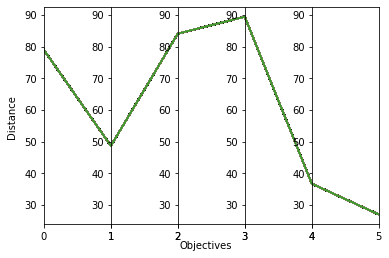

In [ ]:
# create data
x = np.arange(0,6) #OBJECTIVE INDEX
#print(x)
#data = [x,x*2,x*x,np.sqrt(x),-x*x,np.sin(x),np.cos(x)]
#print(data)
  
# make subplots
fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1, 5, sharey=False)
ax = (ax0,ax1,ax2,ax3,ax4)
fig.text(0.5, 0.04, 'Objectives', ha='center')
fig.text(0.04, 0.5, 'Distance', va='center', rotation='vertical')

# plot subplots and set xlimit
for i in range(5):
    for j in range(len(pareto)):
        ax[i].plot(pareto[6,:])
    ax[i].set_xlim([x[i],x[i+1]])
    ax[i].set_xticks([x[i],x[i+1]])

# set width space to zero
plt.subplots_adjust(wspace=0)
#plt.xticks([1,2,3,4,5])
# show plot
plt.show()

IndexError: ignored

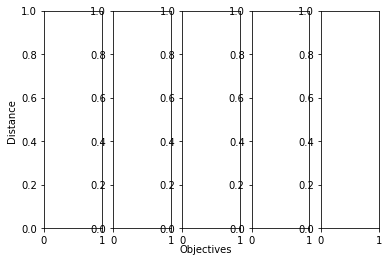

In [ ]:
# create data
x = np.arange(0,6) #OBJECTIVE INDEX
#print(x)
#data = [x,x*2,x*x,np.sqrt(x),-x*x,np.sin(x),np.cos(x)]
#print(data)
  
# make subplots
fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1, 5, sharey=False)
ax = (ax0,ax1,ax2,ax3,ax4)
fig.text(0.5, 0.04, 'Objectives', ha='center')
fig.text(0.04, 0.5, 'Distance', va='center', rotation='vertical')

# plot subplots and set xlimit
for i in range(5):
    for j in range(len(pareto)):
        ax[i].plot(pareto[j,:])
    ax[i].set_xlim([x[i],x[i+1]])
    ax[i].set_xticks([x[i],x[i+1]])

# set width space to zero
plt.subplots_adjust(wspace=0)
#plt.xticks([1,2,3,4,5])
# show plot
plt.show()

In [ ]:
pareto_rem = np.load('/content/drive/MyDrive/DesignBot_Numpy/pareto_rem.npy')
len(pareto_rem)

FileNotFoundError: ignored

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(0)+'_'+str(1)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(0)+'_'+str(1)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(0)+'_'+str(1)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(0)+'_'+str(1)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(0)+'_'+str(1)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_act_log_obt_file_name+'.npy')


(87.02085233625455, 33.18067011210948, 71.47726911403373, 7.211102550927978)

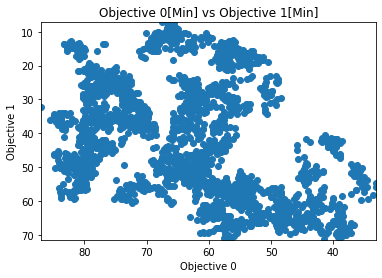

In [ ]:
x = pareto[:,0]
y = pareto[:,1]
plt.scatter(x,y)
plt.title('Objective 0[Min] vs Objective 1[Min]')
plt.xlabel('Objective 0')
plt.ylabel('Objective 1')
plt.axis([max(x),min(x),max(y),min(y)])

(60.0, 0.0, 60.0, 100.0)

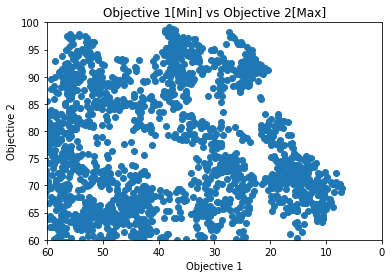

In [ ]:
x = pareto[:,1]
y = pareto[:,2]
plt.scatter(x,y)
plt.title('Objective 1[Min] vs Objective 2[Max]')
plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.axis([60,0,60,100])

Text(0.5, 1.0, 'Best distance over first 500 steps [component 1]')

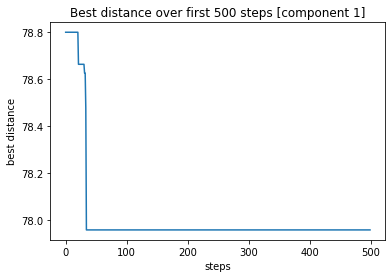

In [ ]:
plt.plot(best_d[0:500])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 500 steps [component 1]')

Text(0.5, 1.0, 'Best distance over all steps[component 1]')

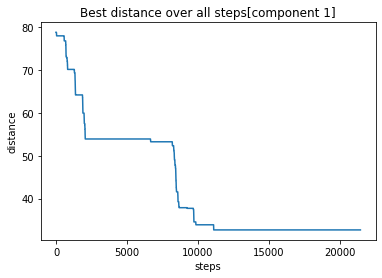

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 1]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 1')

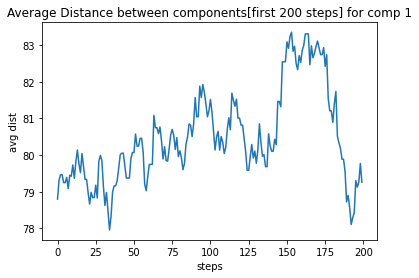

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 1')

In [ ]:
len(avg_d)

21457

Text(0.5, 1.0, 'Average Distance between components - comp1')

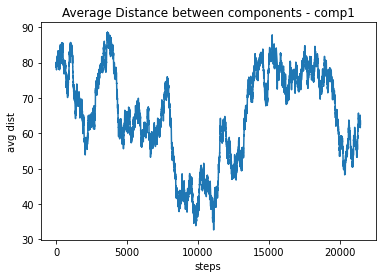

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp1')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 1')

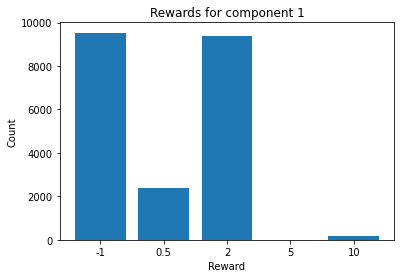

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 1')

Text(0.5, 1.0, 'Rewards for component 1')

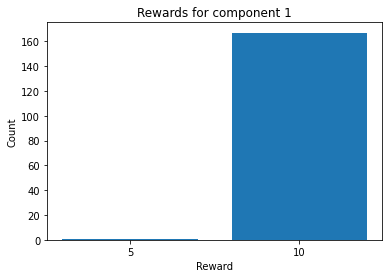

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 1')

Text(0.5, 1.0, 'Exploit vs Explore for component 1')

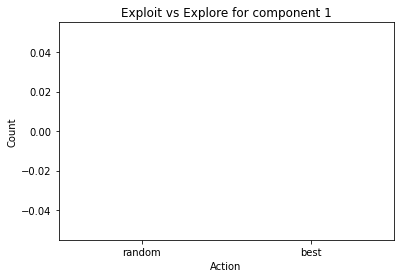

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 1')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(0)+'_'+str(2)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(0)+'_'+str(2)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(0)+'_'+str(2)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(0)+'_'+str(2)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(0)+'_'+str(2)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_act_log_obt_file_name+'.npy')


Text(0.5, 1.0, 'Best distance over first 100 steps [component 2]')

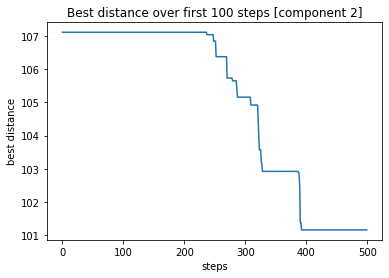

In [ ]:
plt.plot(best_d[0:500])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 2]')

Text(0.5, 1.0, 'Best distance over all steps[component 2]')

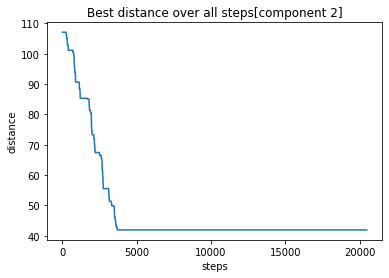

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 2]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 2')

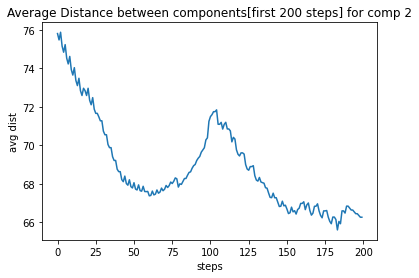

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 2')

Text(0.5, 1.0, 'Average Distance between components - comp 2')

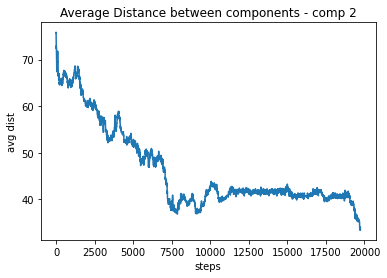

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 2')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 2')

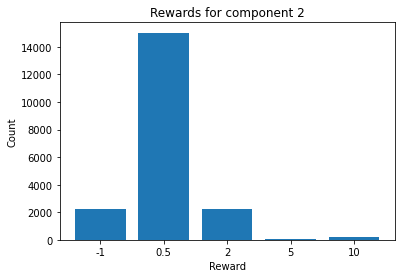

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 2')

Text(0.5, 1.0, 'Rewards for component 2')

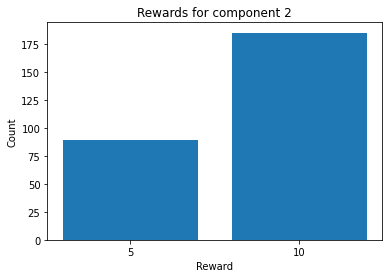

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 2')

Text(0.5, 1.0, 'Exploit vs Explore for component 2')

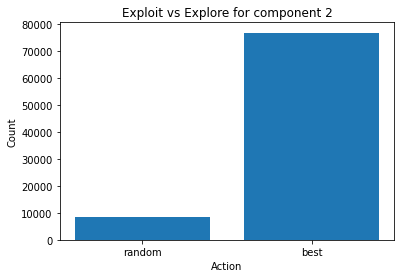

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 2')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(0)+'_'+str(7)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(0)+'_'+str(7)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(0)+'_'+str(7)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(0)+'_'+str(7)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(0)+'_'+str(7)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 500 steps [component 7]')

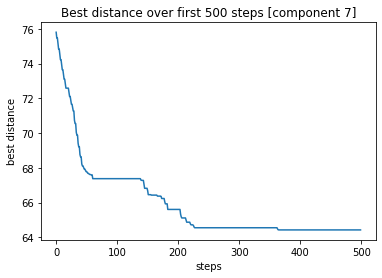

In [ ]:
plt.plot(best_d[0:500])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 500 steps [component 7]')

Text(0.5, 1.0, 'Best distance over all steps[component 7]')

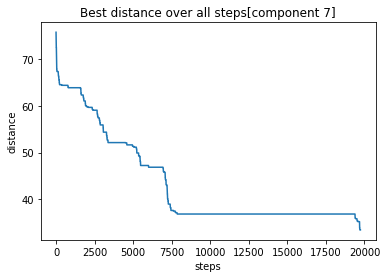

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 7]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 7')

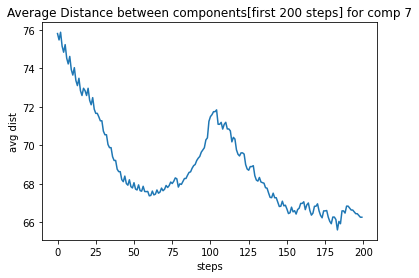

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 7')

Text(0.5, 1.0, 'Average Distance between components - comp 7')

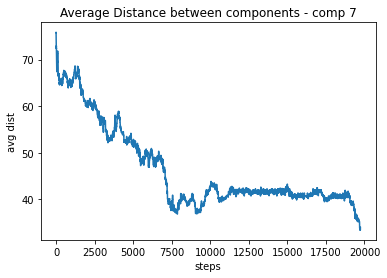

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 7')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 7')

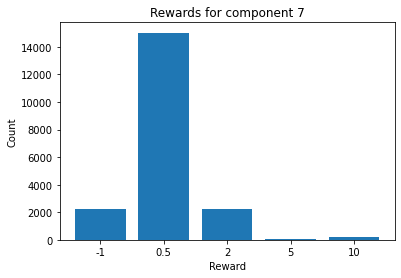

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 7')

Text(0.5, 1.0, 'Rewards for component 7')

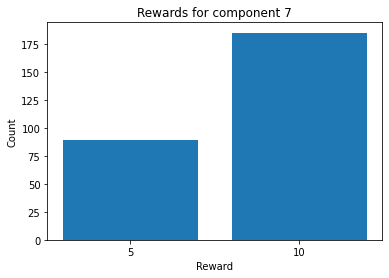

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 7')

Text(0.5, 1.0, 'Exploit vs Explore for component 7')

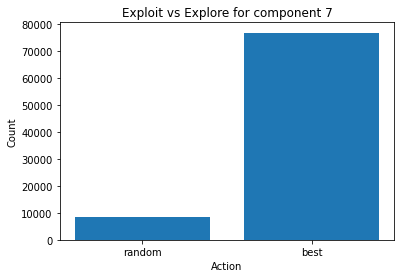

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 7')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(1)+'_'+str(0)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(1)+'_'+str(0)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(1)+'_'+str(0)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(1)+'_'+str(0)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(1)+'_'+str(0)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 100 steps [component 0]')

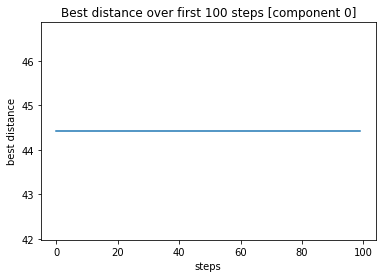

In [ ]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 0]')

Text(0.5, 1.0, 'Best distance over all steps[component 0]')

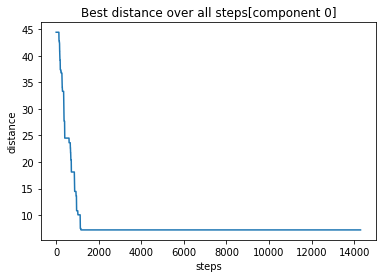

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 0]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 0')

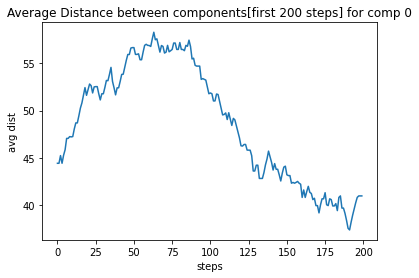

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 0')

Text(0.5, 1.0, 'Average Distance between components - comp 0')

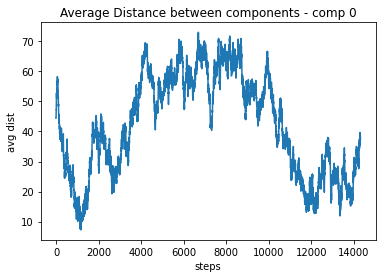

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 0')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 0')

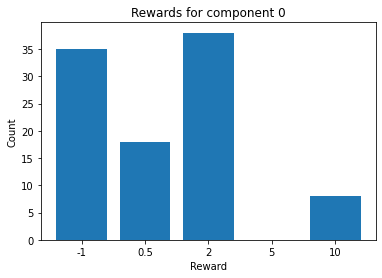

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 0')

Text(0.5, 1.0, 'Rewards for component 0')

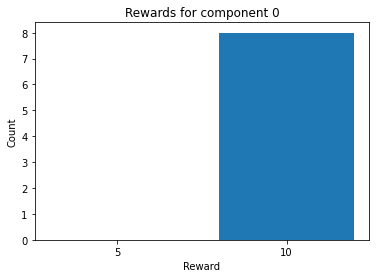

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 0')

Text(0.5, 1.0, 'Exploit vs Explore for component 0')

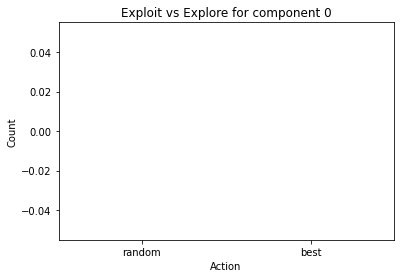

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 0')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(1)+'_'+str(5)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(1)+'_'+str(5)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(1)+'_'+str(5)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(1)+'_'+str(5)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(1)+'_'+str(5)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 100 steps [component 5]')

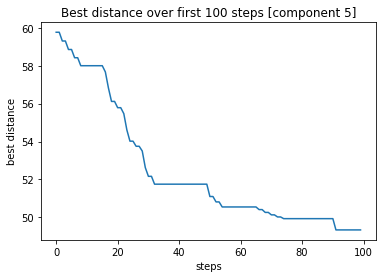

In [ ]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 5]')

Text(0.5, 1.0, 'Best distance over all steps[component 5]')

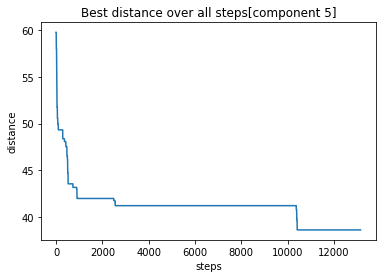

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 5]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 5')

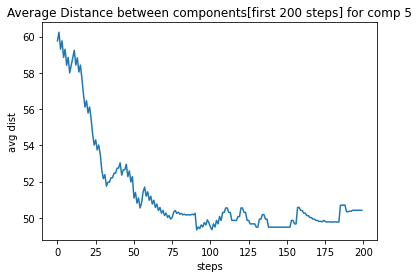

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 5')

Text(0.5, 1.0, 'Average Distance between components - comp 5')

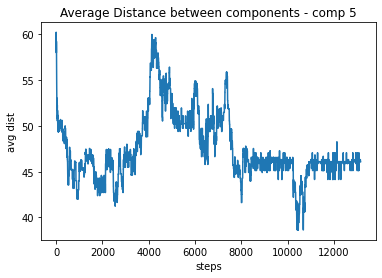

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 5')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 5')

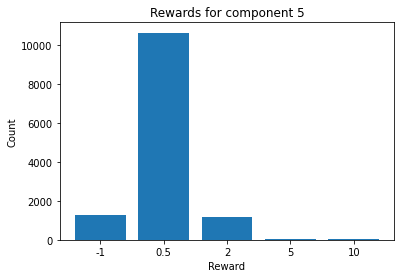

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Rewards for component 5')

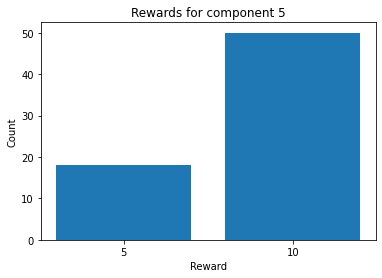

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Exploit vs Explore for component 5')

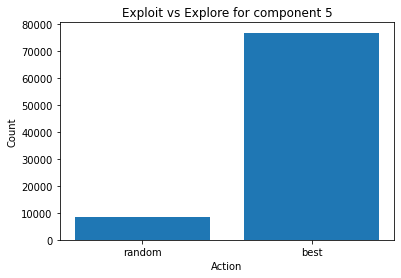

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 5')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(2)+'_'+str(3)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(2)+'_'+str(3)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(2)+'_'+str(3)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(2)+'_'+str(3)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(2)+'_'+str(3)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 100 steps [component 5]')

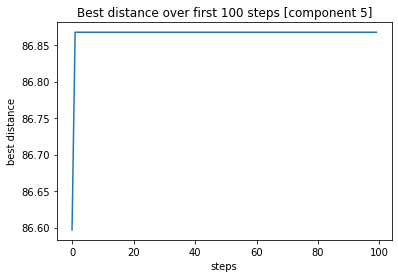

In [ ]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 5]')

Text(0.5, 1.0, 'Best distance over all steps[component 5]')

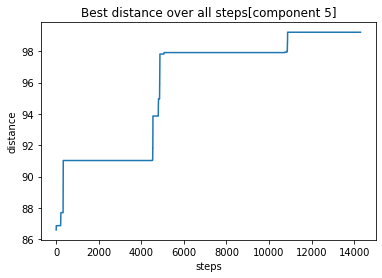

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 5]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 5')

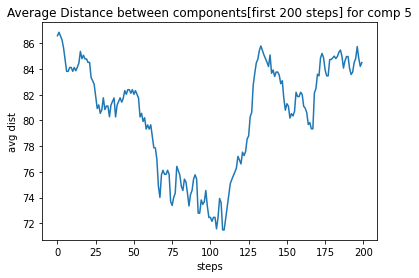

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 5')

Text(0.5, 1.0, 'Average Distance between components - comp 5')

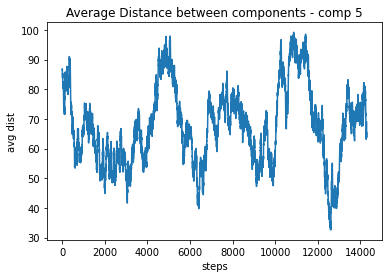

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 5')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 5')

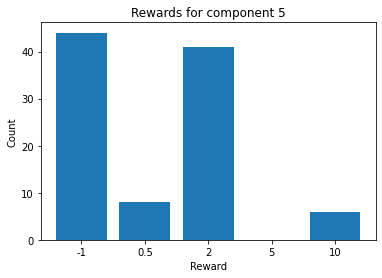

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Rewards for component 5')

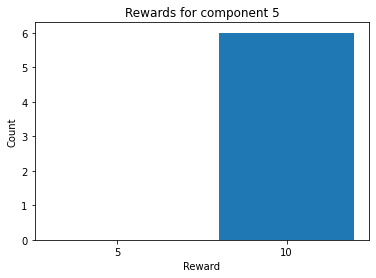

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Exploit vs Explore for component 5')

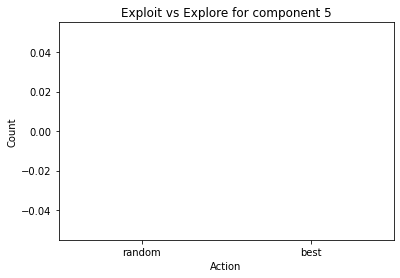

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 5')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(2)+'_'+str(6)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(2)+'_'+str(6)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(2)+'_'+str(6)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(2)+'_'+str(6)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(2)+'_'+str(6)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 100 steps [component 5]')

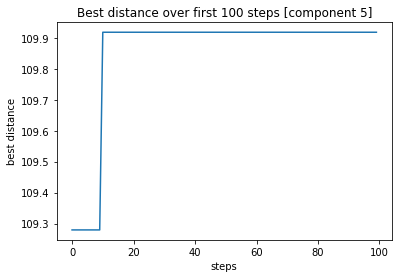

In [ ]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 5]')

Text(0.5, 1.0, 'Best distance over all steps[component 5]')

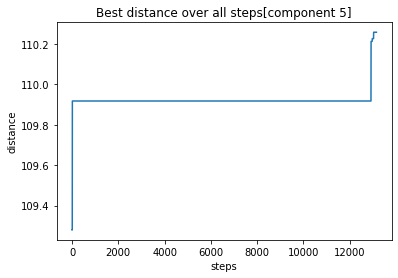

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 5]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 5')

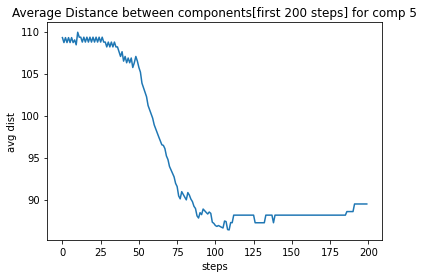

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 5')

Text(0.5, 1.0, 'Average Distance between components - comp 5')

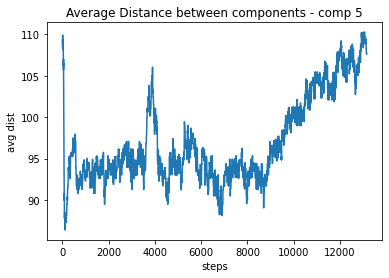

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 5')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 5')

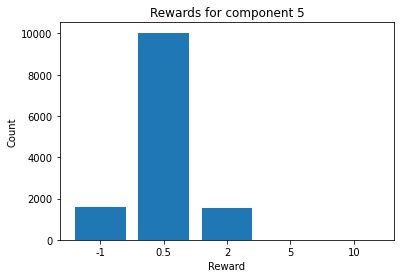

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Rewards for component 5')

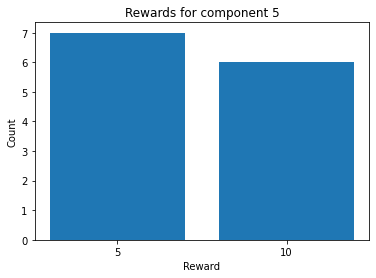

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Exploit vs Explore for component 5')

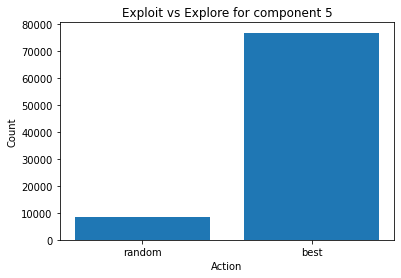

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 5')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(3)+'_'+str(3)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(3)+'_'+str(3)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(3)+'_'+str(3)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(3)+'_'+str(3)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(3)+'_'+str(3)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 100 steps [component 5]')

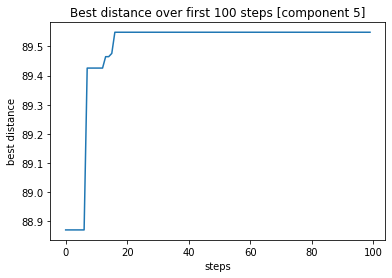

In [ ]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 5]')

Text(0.5, 1.0, 'Best distance over all steps[component 5]')

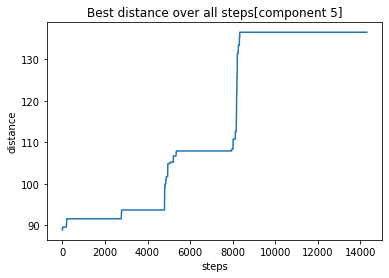

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 5]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 5')

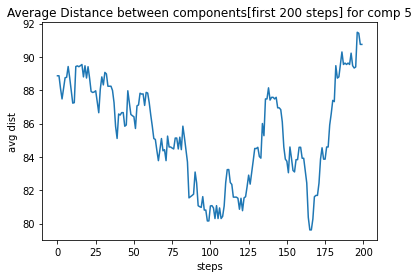

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 5')

Text(0.5, 1.0, 'Average Distance between components - comp 5')

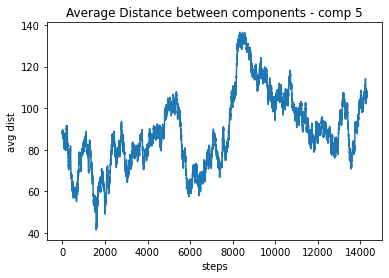

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 5')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 5')

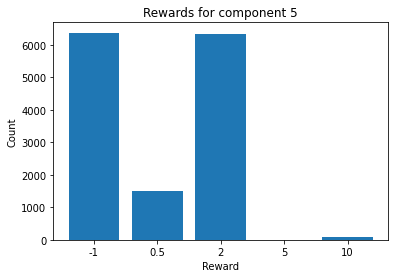

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Rewards for component 5')

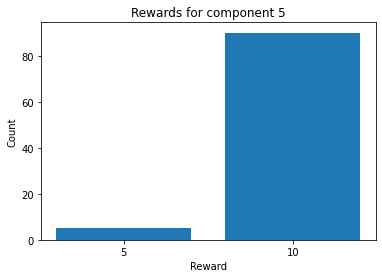

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Exploit vs Explore for component 5')

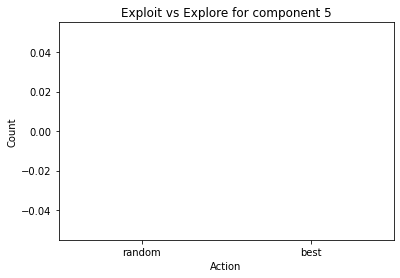

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 5')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(3)+'_'+str(0)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(3)+'_'+str(0)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(3)+'_'+str(0)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(3)+'_'+str(0)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(3)+'_'+str(0)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 100 steps [component 5]')

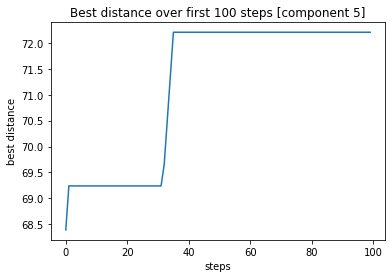

In [ ]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 5]')

Text(0.5, 1.0, 'Best distance over all steps[component 5]')

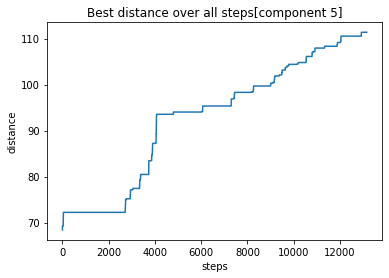

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 5]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 5')

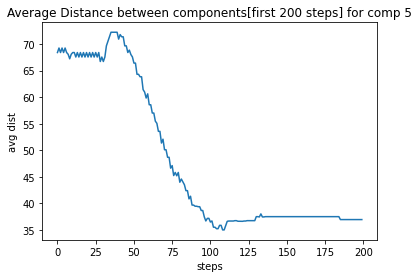

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 5')

Text(0.5, 1.0, 'Average Distance between components - comp 5')

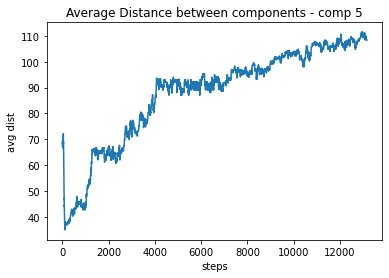

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 5')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 5')

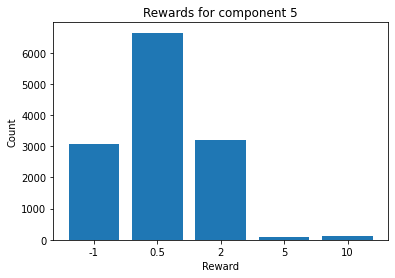

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Rewards for component 5')

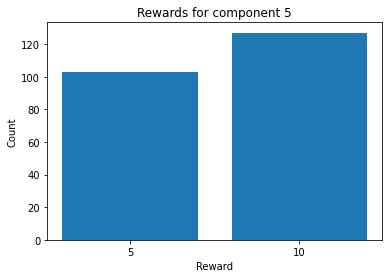

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Exploit vs Explore for component 5')

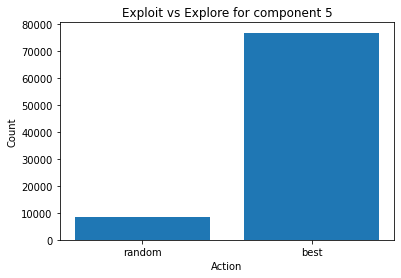

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 5')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(4)+'_'+str(6)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(4)+'_'+str(6)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(4)+'_'+str(6)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(4)+'_'+str(6)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(4)+'_'+str(6)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 100 steps [component 5]')

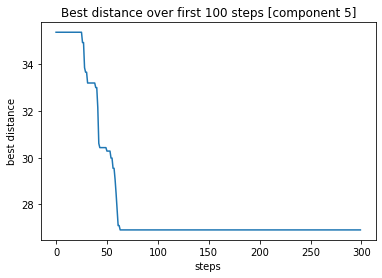

In [ ]:
plt.plot(best_d[0:300])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 5]')

Text(0.5, 1.0, 'Best distance over all steps[component 5]')

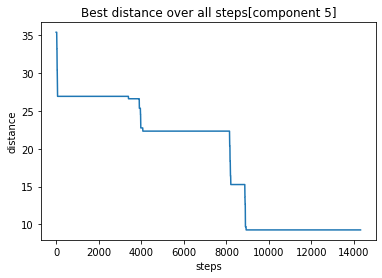

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 5]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 5')

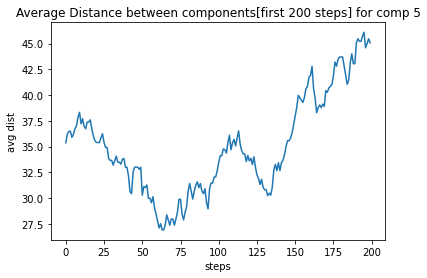

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 5')

Text(0.5, 1.0, 'Average Distance between components - comp 5')

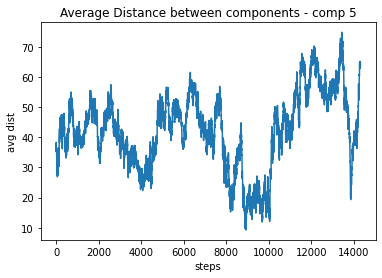

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 5')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 5')

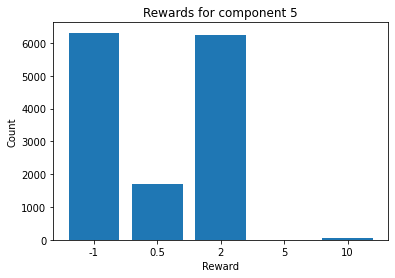

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Rewards for component 5')

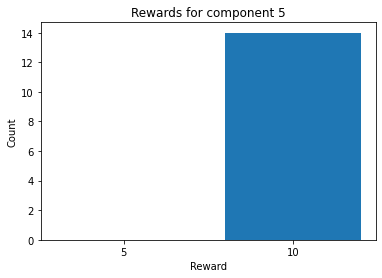

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Exploit vs Explore for component 5')

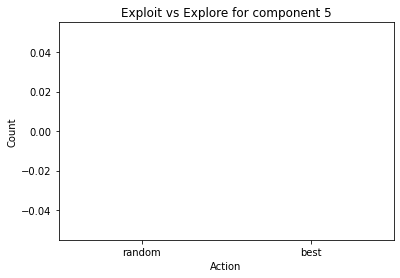

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 5')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(4)+'_'+str(2)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(4)+'_'+str(2)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(4)+'_'+str(2)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(4)+'_'+str(2)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(4)+'_'+str(2)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 100 steps [component 5]')

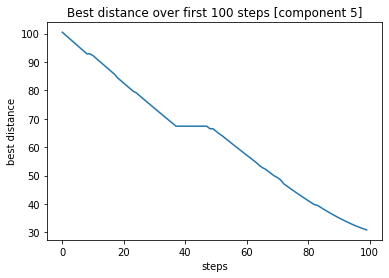

In [ ]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 5]')

Text(0.5, 1.0, 'Best distance over all steps[component 5]')

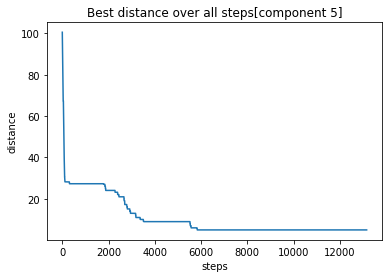

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 5]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 5')

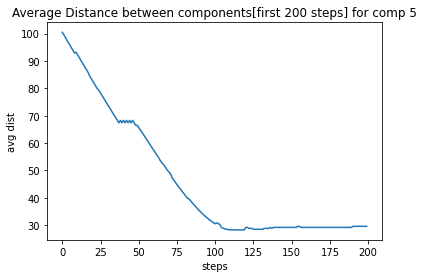

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 5')

Text(0.5, 1.0, 'Average Distance between components - comp 5')

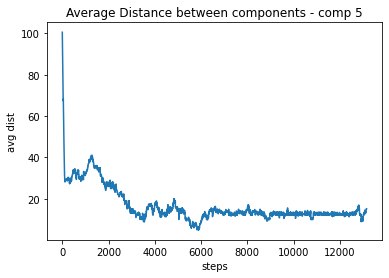

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 5')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 5')

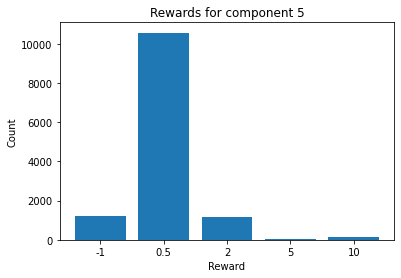

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Rewards for component 5')

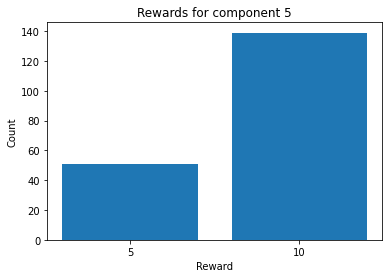

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Exploit vs Explore for component 5')

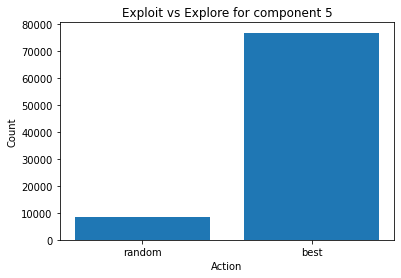

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 5')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(5)+'_'+str(2)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(5)+'_'+str(2)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(5)+'_'+str(2)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(5)+'_'+str(2)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(5)+'_'+str(2)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 100 steps [component 5]')

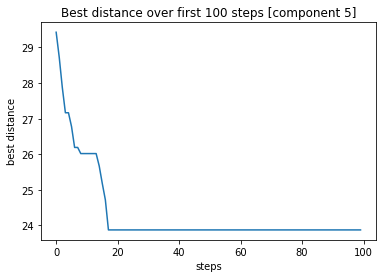

In [ ]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 5]')

Text(0.5, 1.0, 'Best distance over all steps[component 5]')

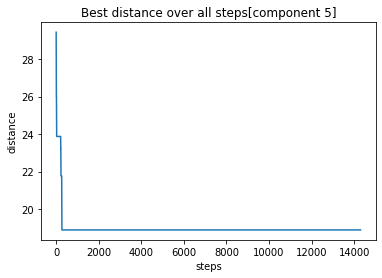

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 5]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 5')

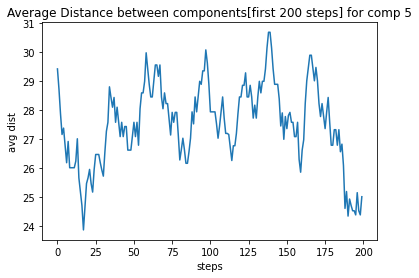

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 5')

Text(0.5, 1.0, 'Average Distance between components - comp 5')

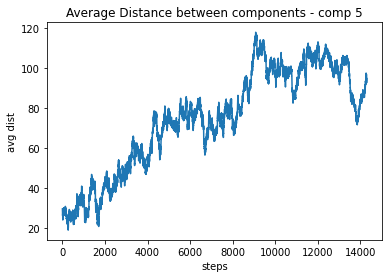

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 5')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 5')

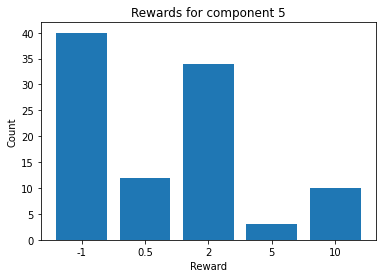

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Rewards for component 5')

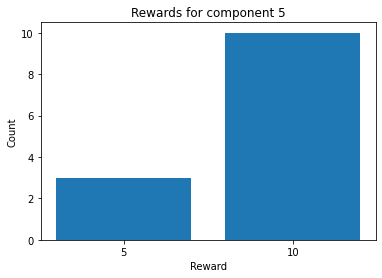

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Exploit vs Explore for component 5')

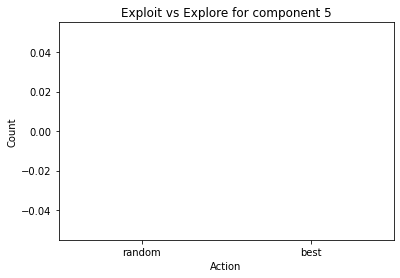

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 5')

In [ ]:
reward_best_d_file_name = 'best_d_glog'+str(5)+'_'+str(4)
best_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_d_file_name+'.npy')

reward_avg_d_file_name = 'avg_d_glog'+str(5)+'_'+str(4)        
avg_d = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_avg_d_file_name+'.npy')

reward_rew_obt_file_name = 'rew_obt_glog'+str(5)+'_'+str(4)        
rew_obt = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_rew_obt_file_name+'.npy')

reward_best_pos_log_obt_file_name = 'rew_best_pos_glog'+str(5)+'_'+str(4)        
best_pos = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_best_pos_log_obt_file_name+'.npy')

reward_act_log_obt_file_name = 'rew_act_glog'+str(5)+'_'+str(4)        
act_log = np.load('/content/drive/MyDrive/DesignBot_Numpy/'+reward_act_log_obt_file_name+'.npy')

Text(0.5, 1.0, 'Best distance over first 100 steps [component 5]')

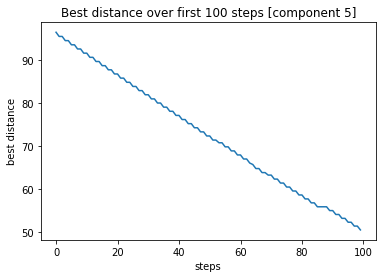

In [ ]:
plt.plot(best_d[0:100])
plt.xlabel('steps')
plt.ylabel('best distance')
plt.title('Best distance over first 100 steps [component 5]')

Text(0.5, 1.0, 'Best distance over all steps[component 5]')

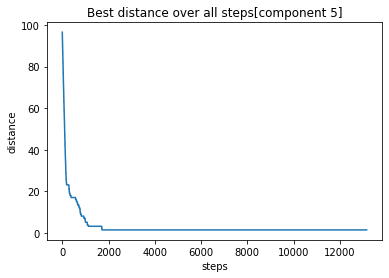

In [ ]:
plt.plot(best_d)
plt.xlabel('steps')
plt.ylabel('distance')
plt.title('Best distance over all steps[component 5]')

Text(0.5, 1.0, 'Average Distance between components[first 200 steps] for comp 5')

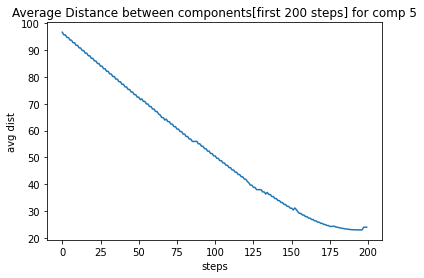

In [ ]:
plt.plot(avg_d[0:200])
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components[first 200 steps] for comp 5')

Text(0.5, 1.0, 'Average Distance between components - comp 5')

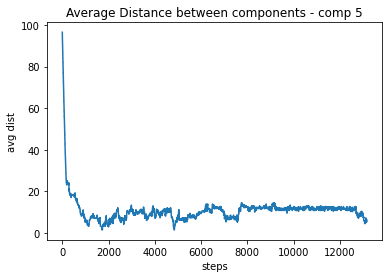

In [ ]:
plt.plot(avg_d)
plt.xlabel('steps')
plt.ylabel('avg dist')
plt.title('Average Distance between components - comp 5')

In [ ]:
point_five = list(rew_obt==0.5).count(True)
neg_rew = list(rew_obt==-1).count(True)
rew_two = list(rew_obt==2).count(True)
rew_five = list(rew_obt==5).count(True)
rew_ten = list(rew_obt==10).count(True)

Text(0.5, 1.0, 'Rewards for component 5')

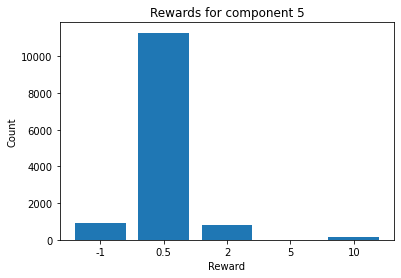

In [ ]:
x = ['-1','0.5','2','5','10']
y = [neg_rew, point_five, rew_two, rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Rewards for component 5')

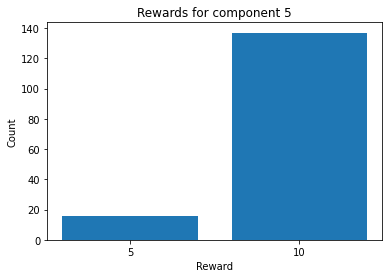

In [ ]:
x = ['5','10']
y = [rew_five, rew_ten]
plt.bar(x,y)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Rewards for component 5')

Text(0.5, 1.0, 'Exploit vs Explore for component 5')

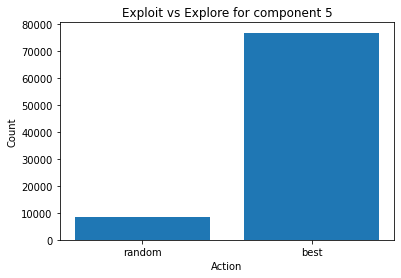

In [ ]:
random_action_cnt = list(act_log).count(0)
best_action_cnt = list(act_log).count(1)
x = ['random','best']
y = [random_action_cnt,best_action_cnt]
plt.bar(x,y)
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Exploit vs Explore for component 5')